## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import syndat
import os
import nuctools

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = syndat.particle_pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1.0])
(-4.0, 2, [1.0, 1.0])
(-3.0, 2, [1.0, 1.0])
(-2.0, 1, [1.0])
(3.0, 1, [0.0])
(4.0, 1, [0.0])


In [4]:
### calc calculate a full energy grid yourself 
E_min_max = [100, 300]
tof_min_max = syndat.exp_effects.e_to_t(np.array(E_min_max),35.185, True)+(3.326)*1e-6
bin_width = 6.4e-9
tof_grid = np.arange(min(tof_min_max), max(tof_min_max), bin_width)
energy_grid = syndat.exp_effects.t_to_e(tof_grid-(3.326)*1e-6,35.185,True)

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = { 'Perform Experiment':True,
            'Add Noise': True,
            'Calculate Covariance': True,
            'Compression Points':[],
            'Grouping Factors':[100]}

experiment_parameters = {'bw': {'val':0.3,    'unc'   :   0}}

# initialize experimental setup
exp = syndat.experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

In [5]:
len(energy_grid)

16800

In [6]:
spin_groups = [ (3.0,1,[0]) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':20.0, '4.0':15.0, '-4.0':15.0},
                                    'Gg'    :   {'3.0':80.0, '4.0':55.0, '-4.0':55.0},
                                    'gn2'    :   {'3.0':50.0, '4.0':10.0, '-4.0':10.0}  })
                                    
                                    
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
resonance_ladder

,E,Gg,gnx2,J,chs,lwave,J_ID
0,123.512956,78.90052,6.377551,3.0,1,[0],1
1,137.739871,75.896552,2.225105,3.0,1,[0],1
2,149.061818,83.116561,29.377994,3.0,1,[0],1
3,158.626111,81.364747,4.164939,3.0,1,[0],1
4,172.269712,78.598215,0.216426,3.0,1,[0],1
5,201.325524,82.345309,66.441071,3.0,1,[0],1
6,228.819942,78.816827,0.224352,3.0,1,[0],1
7,253.842648,78.494847,12.162784,3.0,1,[0],1
8,297.803712,79.778475,60.0096,3.0,1,[0],1


### Calculate cross section using SAMMY

In [7]:
syndat.sammy_interface.calculate_xs(energy_grid, resonance_ladder, Ta_pair)
theo = syndat.sammy_interface.readlst('./SAMMY_runDIR/SAMMY.LST')

In [8]:
theo

,E,exp_dat,exp_dat_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,100.000487,-0.0,14.887599,7.630713,0.0,1.0,1.0,0.598982,NaN
1,100.005519,-0.0,14.887599,7.630712,0.0,1.0,1.0,0.598982,NaN
2,100.010551,-0.0,14.887599,7.630711,0.0,1.0,1.0,0.598982,NaN
3,100.015584,-0.0,14.887599,7.630709,0.0,1.0,1.0,0.598982,NaN
4,100.020617,-0.0,14.887599,7.630708,0.0,1.0,1.0,0.598982,NaN
...,...,...,...,...,...,...,...,...,...
16795,299.895443,-0.0,14.887599,7.934997,0.0,1.0,1.0,0.586864,NaN
16796,299.921577,-0.0,14.887599,7.930122,0.0,1.0,1.0,0.587056,NaN
16797,299.947715,-0.0,14.887599,7.925414,0.0,1.0,1.0,0.587242,NaN
16798,299.973856,-0.0,14.887599,7.920866,0.0,1.0,1.0,0.587421,NaN


### Perform Syndat experiment

In [9]:

exp.run(os.path.realpath('./SAMMY_runDIR/SAMMY.LST'))

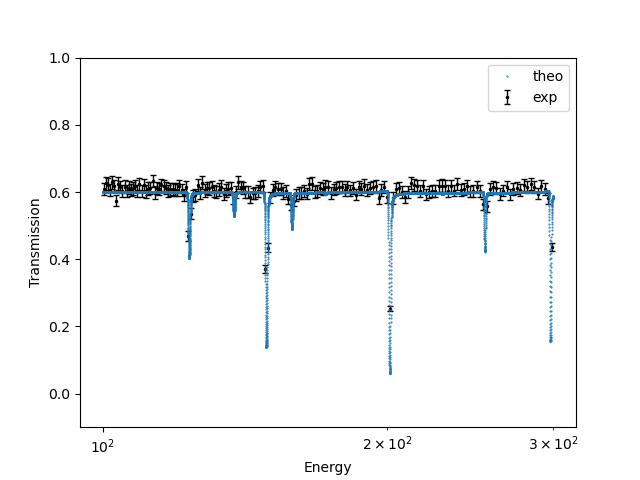

In [10]:
figure()
plot(theo.E, theo.theo_trans, '.', ms=1, label='theo')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

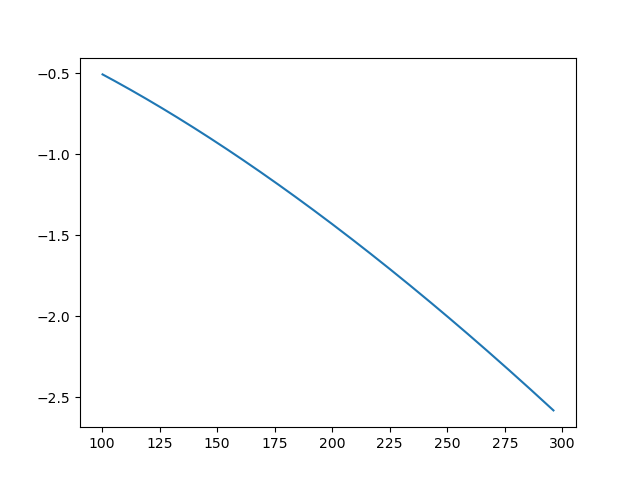

In [11]:
figure()

plot(exp.trans.E[1::], np.diff(exp.trans.E))